In [1]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#df = pd.read_csv("news.csv", index_col=0, error_bad_lines=False)
#df[:5]

In [3]:
df = pd.read_csv("news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
df = df.iloc[:, 1:]
df[:2]

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE


In [5]:
df.shape

(6335, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(6335, 3)

In [10]:
df.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [11]:
df["label_encode"]= df.label.replace({
    "REAL": 1,
    "FAKE": 0
})

In [12]:
#real= df[df.label =="REAL"]
#fake= df[df.label =="FAKE"]

In [13]:
#data= pd.concat([real, fake])
#data.head()

In [14]:
data= df.sample(3000)

In [15]:
data.label_encode.value_counts()

1    1501
0    1499
Name: label_encode, dtype: int64

In [16]:
data[:3]

,title,text,label,label_encode
5324,May Day's meaning: How it unfolded in Seattle,SEATTLE — Police say black-clad May Day marche...,REAL,1
3570,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",FAKE,0
3278,Week of Donald Trump-Hillary Clinton feud a ta...,Washington (CNN) Donald Trump's attacks agains...,REAL,1


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.text, data.label_encode, stratify= data.label_encode)

In [18]:
X_train.head()

214     New Report Finds Voters Have No Idea How Outra...
1169    Why Obama Has His Work Cut Out For Him On Gett...
2524    — Dr.Darrell Scott (@PastorDScott) October 27,...
4759    Decorah, Iowa (CNN) It was the most legendary ...
3532    Donald Trump has dominated the GOP presidentia...
Name: text, dtype: object

In [19]:
X_train.shape

(2250,)

In [20]:
y_train.value_counts()

1    1126
0    1124
Name: label_encode, dtype: int64

In [21]:
bert_preprocess= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
#Bert layers
input= tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(input)
encoded_text = bert_encoder(preprocessed_text)

In [23]:
# Neural network layers
dropout = tf.keras.layers.Dropout(0.1, name="dropout")(encoded_text['pooled_output'])
output_l= tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout)

In [24]:
# Building the final model with inputs and outputs
model = tf.keras.Model(inputs=[input], outputs= [output_l])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [26]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [28]:
y_train = np.asarray(y_train).astype(np.float32)

In [29]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
71/71 [==============================] - 1036s 14s/step - loss: 0.6746 - accuracy: 0.5791 - precision: 0.5742 - recall: 0.6155
Epoch 2/20
71/71 [==============================] - 1023s 14s/step - loss: 0.6241 - accuracy: 0.6573 - precision: 0.6586 - recall: 0.6545
Epoch 3/20
71/71 [==============================] - 1008s 14s/step - loss: 0.5672 - accuracy: 0.7262 - precision: 0.7285 - recall: 0.7220
Epoch 4/20
71/71 [==============================] - 1016s 14s/step - loss: 0.5368 - accuracy: 0.7533 - precision: 0.7520 - recall: 0.7567
Epoch 5/20
71/71 [==============================] - 1015s 14s/step - loss: 0.5176 - accuracy: 0.7667 - precision: 0.7615 - recall: 0.7771
Epoch 6/20
71/71 [==============================] - 1009s 14s/step - loss: 0.4983 - accuracy: 0.7822 - precision: 0.7839 - recall: 0.7798
Epoch 7/20
71/71 [==============================] - 1012s 14s/step - loss: 0.4819 - accuracy: 0.7902 - precision: 0.7853 - recall: 0.7993
Epoch 8/20
71/71 [================

In [30]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 341s 14s/step - loss: 0.3729 - accuracy: 0.8547 - precision: 0.8500 - recall: 0.8613


[0.3728755712509155,
 0.8546666502952576,
 0.8500000238418579,
 0.8613333106040955]

In [31]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

24/24 [==============================] - 336s 14s/step


In [32]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,

In [33]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       375
           1       0.85      0.86      0.86       375

    accuracy                           0.85       750
   macro avg       0.85      0.85      0.85       750
weighted avg       0.85      0.85      0.85       750



In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[318,  57],
       [ 52, 323]])

Text(50.722222222222214, 0.5, 'Truth')

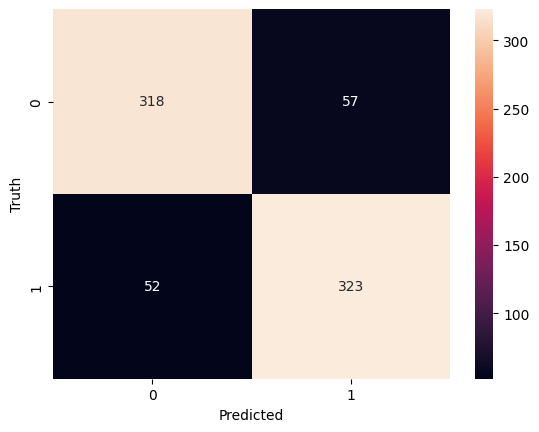

In [35]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [36]:
model.save("./bert_text_classification")